In [4]:
import os, math
from collections import defaultdict
import itertools
import sqlite3

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdv import *

In [5]:
config = Config('SQLITE3')
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

In [9]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 6.2 μs


((10000, 3), (2000, 3))

In [10]:
df_train_images.head()

,index,value,png
image_id,,,
47309,0,8,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
49806,1,7,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
5867,2,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
22851,3,6,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
47609,4,5,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [46]:
df_first_encoding = pd.read_sql_query('SELECT * FROM image_encodings LIMIT 1', con=train_db_con)
assert len(df_first_encoding) > 0
IMAGE_ENCODING_DIMS = np.frombuffer(df_first_encoding.iloc[0]['data'], dtype='b').shape[0]
assert IMAGE_ENCODING_DIMS > 0
IMAGE_ENCODING_DIMS

4096

In [11]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))

In [34]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image


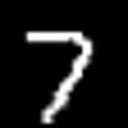
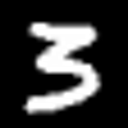
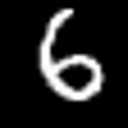
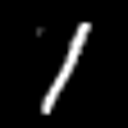
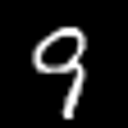
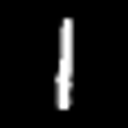
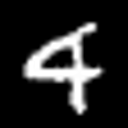
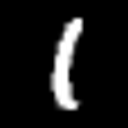
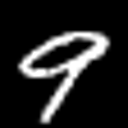
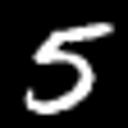
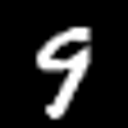
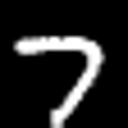
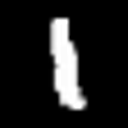
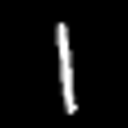
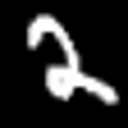
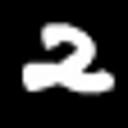

In [54]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [55]:
COS_SIM_THRESHOLD = 0.075
hdv = Hdv(10_000, np)

In [56]:
def generate_permutation_matrix(input_vector_dims):
    pm = np.zeros((input_vector_dims, input_vector_dims), dtype='b')
    row_indices = RNG.choice(pm.shape[0], pm.shape[0], replace=False)
    
    for row_index, column_index in zip(row_indices, range(pm.shape[1])):
        pm[row_index, column_index] = 1

    return pm

In [57]:
pm = generate_permutation_matrix(100)
assert np.array_equal((pm == 1).sum(axis=0), np.ones(pm.shape[0]))
assert np.array_equal((pm == 1).sum(axis=1), np.ones(pm.shape[0]))
rand_vec = RNG.integers(0, 2, pm.shape[0])
mutated_rand_vec = pm @ rand_vec
assert np.array_equal(pm.T @ mutated_rand_vec, rand_vec)
assert np.array_equal(np.unique_counts(rand_vec).counts, np.unique_counts(mutated_rand_vec).counts)

In [75]:
class CorticalColumn(object):
    def __init__(self, input_vector_dims, stride_width, strides_count):
        #self.input_vector_permutation2 = generate_permutation_matrix(input_vector_dims)
        self.stride_width = stride_width
        self.stride_hdvs = defaultdict(hdv)

        assert input_vector_dims >= stride_width
        total_strides = input_vector_dims // stride_width
        assert strides_count <= total_strides
        self.stride_indices = RNG.choice(total_strides, strides_count, replace=False)
        self.stride_indices *= stride_width
        assert np.all(np.unique_counts(self.stride_indices).counts == 1)
        
        self.stage_norm_hdvs = []
        self.conso_norm_hdvs = np.zeros(shape=(0, hdv.N))
        self.stage_norm_hdv_index_to_image_id = dict()
        self.conso_norm_hdv_index_to_image_id = dict()

    def remember(self, norm_hdv, image_id):
        assert image_id > -1
        assert norm_hdv.shape == (hdv.N,)
        self.stage_norm_hdvs.append(norm_hdv)
        norm_hdv_index = len(self.stage_norm_hdvs) - 1
        assert norm_hdv_index > -1
        self.stage_norm_hdv_index_to_image_id[norm_hdv_index] = image_id

In [124]:
CORTICAL_COLUMNS_COUNT = 1
CORTICAL_COLUMNS = []
#CORTICAL_COLUMNS_PMS = np.zeros((CORTICAL_COLUMNS_COUNT, IMAGE_ENCODING_DIMS, IMAGE_ENCODING_DIMS))
stride_width = 16

for i in range(CORTICAL_COLUMNS_COUNT):
    if i % 5 == 0:
        column = CorticalColumn(IMAGE_ENCODING_DIMS, stide_width, IMAGE_ENCODING_DIMS // stride_width)
    else:
        column = CorticalColumn(IMAGE_ENCODING_DIMS, stide_width, IMAGE_ENCODING_DIMS // (stride_width * 8))
    
    CORTICAL_COLUMNS.append(column)
    #CORTICAL_COLUMNS_PMS[i] = column.input_vector_permutation2
    #CORTICAL_COLUMNS_PMS[i] = generate_permutation_matrix(IMAGE_ENCODING_DIMS)

assert len(CORTICAL_COLUMNS) == CORTICAL_COLUMNS_COUNT

In [128]:
count = 1000
df_train_images_subset = df_train_images.head(count)
image_ids = df_train_images_subset.index # aka image_id
df_encodings = pd.read_sql(f'SELECT * FROM image_encodings WHERE image_id IN ({','.join(map(str, image_ids))}) AND offset_x = 0 AND offset_y = 0', con=train_db_con)

for _, df_encodings_row in tqdm(df_encodings.iterrows(), total=count):
    image_id = int(df_encodings_row['image_id'])
    image_encoding = np.frombuffer(df_encodings_row['data'], dtype='b')
    #image_encoding_for_columns = CORTICAL_COLUMNS_PMS @ image_encoding # Permutation is very expensive. On CPU slowdown is 13 times!
    image_encoding_for_columns = map(lambda _: image_encoding, CORTICAL_COLUMNS)
    
    # Ощупываем image с разных сторон, аггресивно запоминаем всё подряд
    for column_index, (column, image_encoding_for_column) in enumerate(zip(CORTICAL_COLUMNS, image_encoding_for_columns)):
        #image_encoding_for_column = column.input_vector_permutation @ image_encoding
        column_norm_hdv = []
    
        for stride_index in column.stride_indices:
            stride = image_encoding_for_column[stride_index:stride_index + column.stride_width]

            if np.all(stride == 0):
                continue
                
            stride_code = ''.join(map(str, stride.tolist()))
            stride_hdv = column.stride_hdvs[stride_code]
            stride_hdv = hdv.shift(stride_hdv, stride_index)
            column_norm_hdv.append(stride_hdv)

        if column_norm_hdv:
            column_norm_hdv = hdv.bundle_noties(column_norm_hdv)
            column_norm_hdv = hdv.normalize(column_norm_hdv)
            column.remember(column_norm_hdv, image_id)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [129]:
# Consolidate memory
for column in CORTICAL_COLUMNS:
    if column.stage_norm_hdvs:
        offset = column.conso_norm_hdvs.shape[0]
        offsetted_mapping = map(lambda p: (p[0] + offset, p[1]), column.stage_norm_hdv_index_to_image_id.items())
        column.conso_norm_hdvs = np.append(column.conso_norm_hdvs, column.stage_norm_hdvs, axis=0)
        column.conso_norm_hdv_index_to_image_id.update(offsetted_mapping)

    column.stage_norm_hdvs = []
    column.stage_norm_hdv_index_to_image_index = dict()

In [130]:
def get_consensus_table(image_encoding):
    table = defaultdict(list)
    #image_encoding_for_columns = CORTICAL_COLUMNS_PMS @ image_encoding # Permutation is very expensive. On CPU slowdown is 13 times!
    image_encoding_for_columns = map(lambda _: image_encoding, CORTICAL_COLUMNS)
    
    for column_index, (column, image_encoding_for_column) in enumerate(zip(CORTICAL_COLUMNS, image_encoding_for_columns)):
        column_norm_hdv = []
    
        for stride_index in column.stride_indices:
            stride = image_encoding_for_column[stride_index:stride_index + column.stride_width]

            if np.all(stride == 0):
                continue

            stride_code = ''.join(map(str, stride.tolist()))
            stride_hdv = column.stride_hdvs[stride_code]
            stride_hdv = hdv.shift(stride_hdv, stride_index)
            column_norm_hdv.append(stride_hdv)

        if not column_norm_hdv:
            continue
            
        column_norm_hdv = hdv.bundle_noties(column_norm_hdv)
        column_norm_hdv = hdv.normalize(column_norm_hdv)
    
        cos_sims = column.conso_norm_hdvs @ column_norm_hdv # this will compute cos sim against all HDVs
        candidate_hdv_indices = np.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)

        for candidate_hdv_index in candidate_hdv_indices:
            cos_sim = cos_sims[candidate_hdv_index]
            candidate_image_id = column.conso_norm_hdv_index_to_image_id[candidate_hdv_index]
            table['column_index'].append(column_index)
            table['image_id'].append(candidate_image_id)
            table['sim'].append(cos_sim)

    return table

In [131]:
%%time
count = 100
images_row = []
image_protos_rows = [[], [], []]
images_captions = []
image_protos_captions = [[], [], []]
inference_table = []

def get_image_safe(df, image_id):
    if image_id < 0:
        return Image.new('L', size=(1,1), color=255)

    image_data = df.loc[image_id]['png']
    return Image.open(io.BytesIO(image_data))

test_image_ids = RNG.choice(df_test_images.index.unique(), count, replace=False)
    
for image_id in tqdm(test_image_ids):
    images_row.append(image_id)
    true_value = df_test_images.loc[image_id]['value']
    images_captions.append(f'#{image_id}, val={true_value}')
    
    inference_record = [image_id, int(true_value)]
    df_encodings = pd.read_sql(f'SELECT * FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=test_db_con)
    
    for _, df_encoding_row in df_encodings.iterrows():
        image_variant_encoding = np.frombuffer(df_encoding_row['data'], dtype='b')
        consensus_table = get_consensus_table(image_variant_encoding)

        if len(consensus_table) == 0:
            continue

        consensus_table = pd.DataFrame(consensus_table, columns=['column_index', 'image_id', 'sim'])
        assert len(consensus_table) > 0
        image_protos = pd.pivot_table(consensus_table, 
                                      index=['image_id'], 
                                      values=['sim', 'column_index'], 
                                      aggfunc={'sim': 'sum', 'column_index': 'nunique'},
                                      sort=False)
        image_protos = image_protos[(image_protos[('column_index')] >= len(CORTICAL_COLUMNS) * 0.75)]
        image_protos.sort_values(by=['column_index', 'sim'], ascending=[False, False], inplace=True)

        if len(image_protos) > 0:
            break
    else:
        image_protos = pd.DataFrame(columns=['dummy'])

    for row, captions, image_proto in itertools.zip_longest(image_protos_rows, image_protos_captions, image_protos.iterrows()):
        if row is None:
            break
            
        image_proto_id, votes, cos_sim = (-1, 0, 0) if image_proto is None else (int(image_proto[0]), int(image_proto[1]['column_index']), image_proto[1]['sim'])
        row.append(image_proto_id)
        inferred_value = int(df_train_images.loc[image_proto_id]['value']) if image_proto_id >= 0 else -1
        captions.append(f'#{image_proto_id}, votes={votes}, sim={cos_sim:.2f}, val={inferred_value}')

        if len(inference_record) < 3:
            inference_record.append(inferred_value)

    inference_table.append(inference_record)

test_images = list(map(lambda image_id: get_image_safe(df_test_images, image_id), images_row))
train_images = list(map(lambda image_id: get_image_safe(df_train_images, image_id), itertools.chain.from_iterable(image_protos_rows)))
df = pd.DataFrame(inference_table, columns=['test_image_id', 'true value', 'infer. value'])
df['is_match'] = df['true value'] == df['infer. value']
print(f'ACCURACY = {df['is_match'].sum() / len(df) * 100:.2f}% (matched {df['is_match'].sum()} of {len(df)})')
df.head()

  0%|          | 0/100 [00:00<?, ?it/s]

ACCURACY = 60.00% (matched 60 of 100)
CPU times: user 27 s, sys: 72.5 ms, total: 27 s
Wall time: 2.39 s


,test_image_id,true value,infer. value,is_match
0,100009593,1,1,True
1,100004241,0,0,True
2,100000425,4,4,True
3,100002592,0,3,False
4,100007164,8,5,False



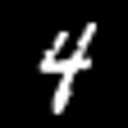
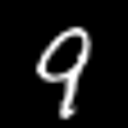
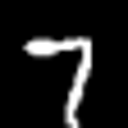
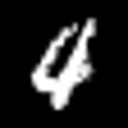
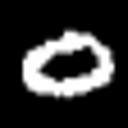
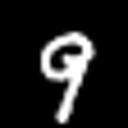
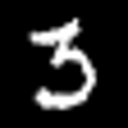
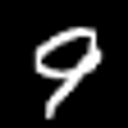
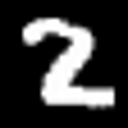
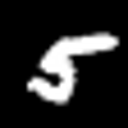
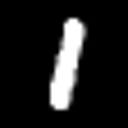
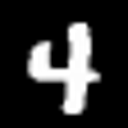
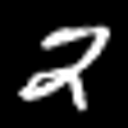
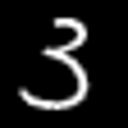
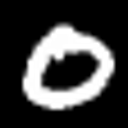
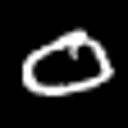
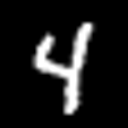
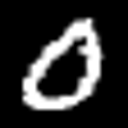
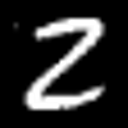
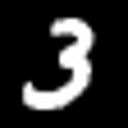
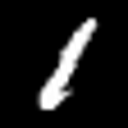
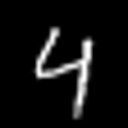
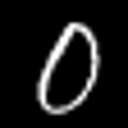
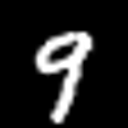
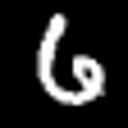
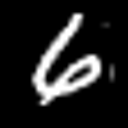
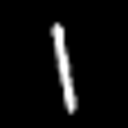
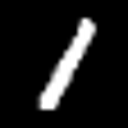
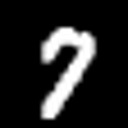
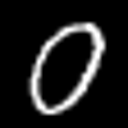
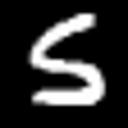
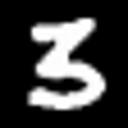
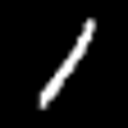
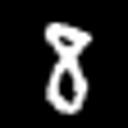
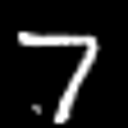
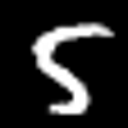
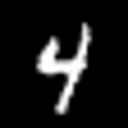
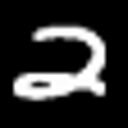
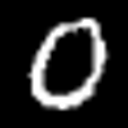
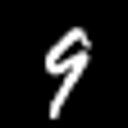
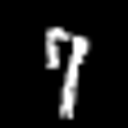
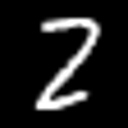
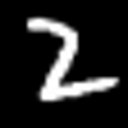
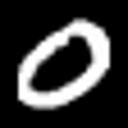
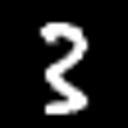
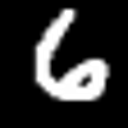
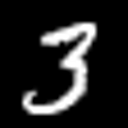
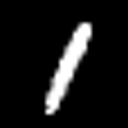
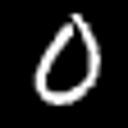
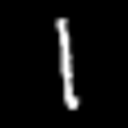
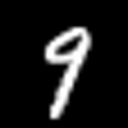
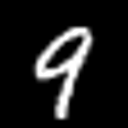
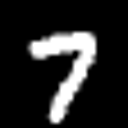
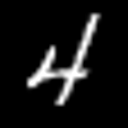
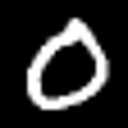
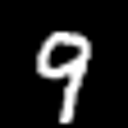
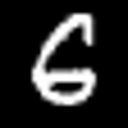
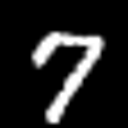
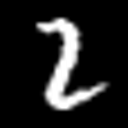
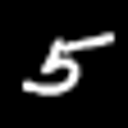
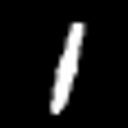
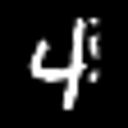
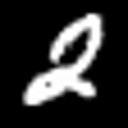
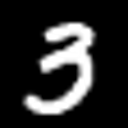
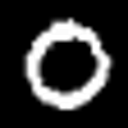
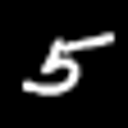
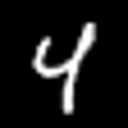
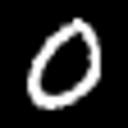
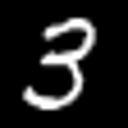
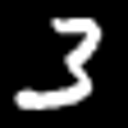
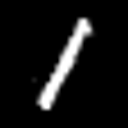
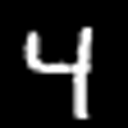
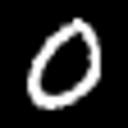
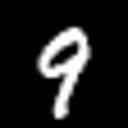
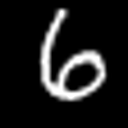
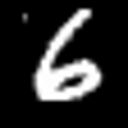
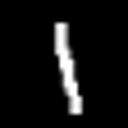
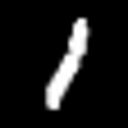
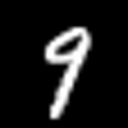
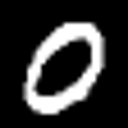
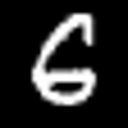
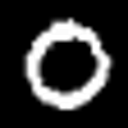
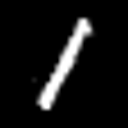
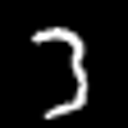
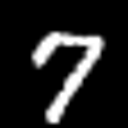
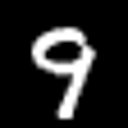
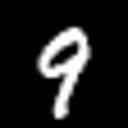
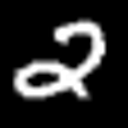
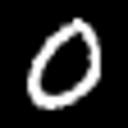
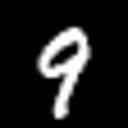
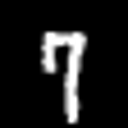
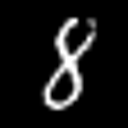
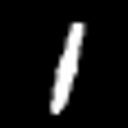
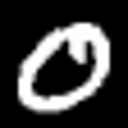
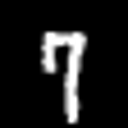
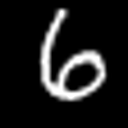
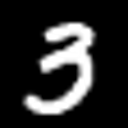
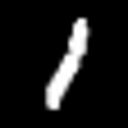
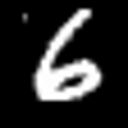
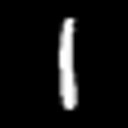
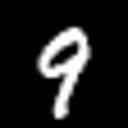
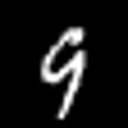
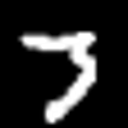
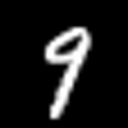
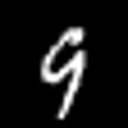
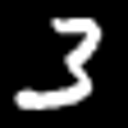
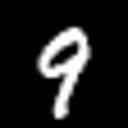
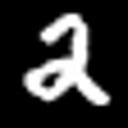
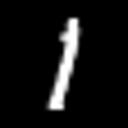
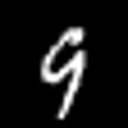
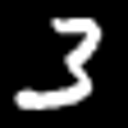
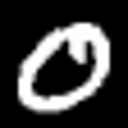
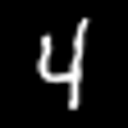
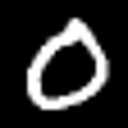
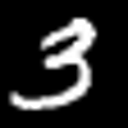
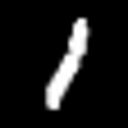
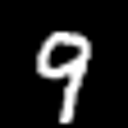
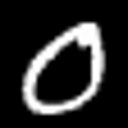
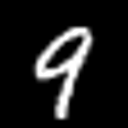
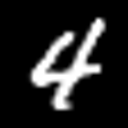
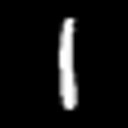
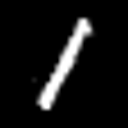
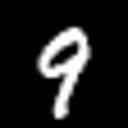
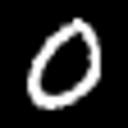
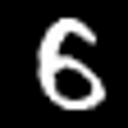
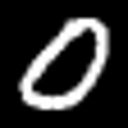
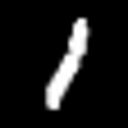
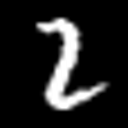
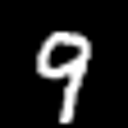
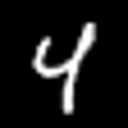
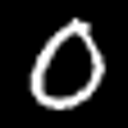
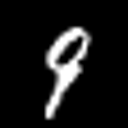
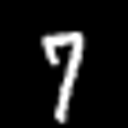
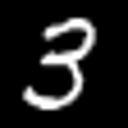
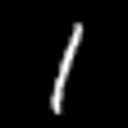
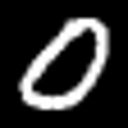
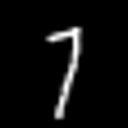
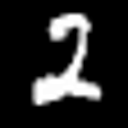
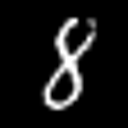
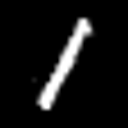
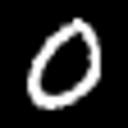
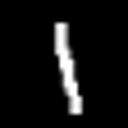
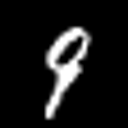
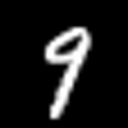
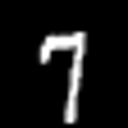
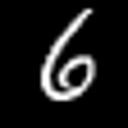
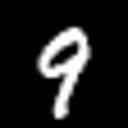
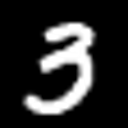
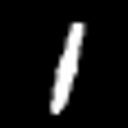
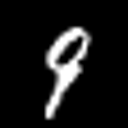
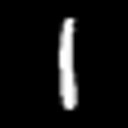
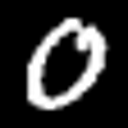
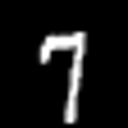
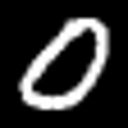
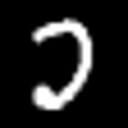
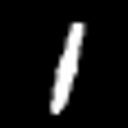
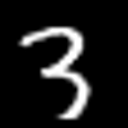
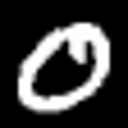
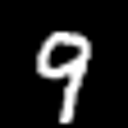
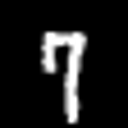
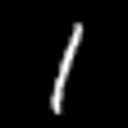
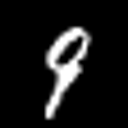
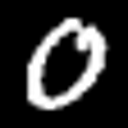
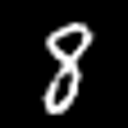
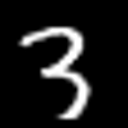
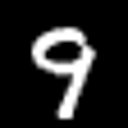
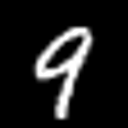
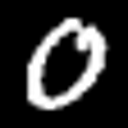
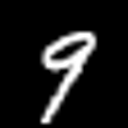
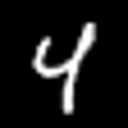
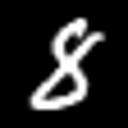
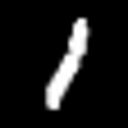
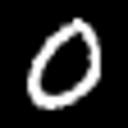
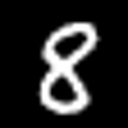
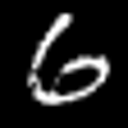
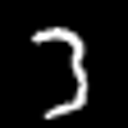
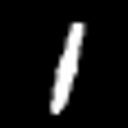
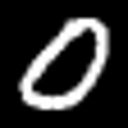
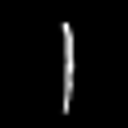

In [102]:
display_images_grid(test_images+train_images,
                    col_count=count, 
                    captions=images_captions + list(itertools.chain.from_iterable(image_protos_captions)))